In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
from architecture import Autoencoder, small_ae, mid_ae, large_ae, larger_ae, larger_ae_mp, REDNet10, REDNet20
from dataset import Dataset
from PIL import Image
from torchvision.utils import save_image
import os
from matplotlib import pyplot as plt

from glob import glob
from pathlib import Path
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_decoded_image(img, name):
    #img = img.view(img.size(0), 1, 100, 100)
    save_image(img, name)

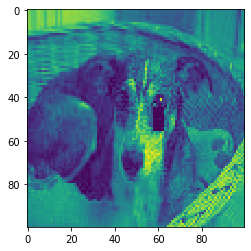

In [2]:
dd = Dataset()
dd_loader = torch.utils.data.DataLoader(dd, batch_size=32, num_workers=2, drop_last=True)

trans = transforms.ToPILImage()
tt = trans(dd_loader.dataset[5][1])
plt.imshow(tt)


In [25]:
net = REDNet20(num_features = 128)

try:
    os.makedirs('output/alts')
    os.makedirs('output/results')
except:
	pass

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

def train(net, loader, optimizer, epochs = 5, mode = 'ae_bn'):
    losses = []
    for epoch in range(epochs):
        rloss = 0.0
        for i, data in enumerate(loader):
            real, cropped = data
            #cropped = torch.clamp(cropped, 0., 1.)
            real = real.to(device)
            cropped = cropped.to(device)
            optimizer.zero_grad()
            output = net(cropped)
            loss = criterion(output, real)
            loss.backward()
            optimizer.step()
            rloss += loss.item()
            if i % 200 == 0 and mode == 'ae_bn':
                save_decoded_image(cropped.cpu().data, f'output/alts/dam{i}_epoch{epoch}.jpg')
                save_decoded_image(output.cpu().data, f'output/alts/recon{i}_epoch{epoch}.jpg')
            elif i % 200 == 0 and mode == 'ae':
                save_decoded_image(cropped.cpu().data, f'output/results/dam{i}_epoch{epoch}.jpg')
                save_decoded_image(output.cpu().data, f'output/results/recon{i}_epoch{epoch}.jpg')
        
        loss = rloss / len(loader.dataset)
        losses.append(loss)
        print(f'Epoch {epoch+1} / {epochs} |' + \
              f'Loss: {loss}')
        
    return losses

In [27]:
try:
    os.makedirs('test_outs')
except:
	pass

def reconstruct(net, loader):
    for i, data in enumerate(loader):
        data = data.to(device)
        output = net(data)
        #save_image(data, f'test_imgs/damaged_input_{i}.jpg')
        #output.save(f'test_outs/recon_output_{i}.jpg')
        save_image(output, f'test_outs/{i}.jpg')

In [28]:
net.load_state_dict(torch.load('saves/rednet20_31ep.pth'))

<All keys matched successfully>

In [29]:
net.to(device)

training = train(net, dd_loader, optimizer, mode='ae_bn')
training

Epoch 1 / 5 |Loss: 1.1610123144379048e-05
Epoch 2 / 5 |Loss: 1.0645213289634697e-05
Epoch 3 / 5 |Loss: 1.109011324101319e-05
Epoch 4 / 5 |Loss: 1.0513168707014654e-05
Epoch 5 / 5 |Loss: 1.0499770915972053e-05


[1.1610123144379048e-05,
 1.0645213289634697e-05,
 1.109011324101319e-05,
 1.0513168707014654e-05,
 1.0499770915972053e-05]

In [31]:
torch.save(net.state_dict(), 'saves/rednet20_36ep.pth')

250

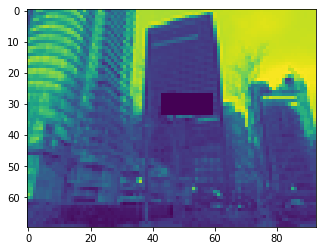

In [17]:
import pickle
import numpy as np

with open('challenge_testset.pkl', 'rb') as f:
    test_data = pickle.load(f)

plt.imshow(Image.fromarray(test_data['images'][3]))

ttest_data = transforms.Compose([transforms.ToPILImage()])
tt = transforms.ToTensor()
orig_shapes = []
new_test = []

for i in test_data['images']:
    orig_shapes.append(i.shape)
    i = tt(i)
    new_test.append(i)

test_loader = torch.utils.data.DataLoader(dataset=new_test, batch_size=1)

len(test_loader.dataset)

In [18]:
net.to(device)

reconstruct(net, test_loader)

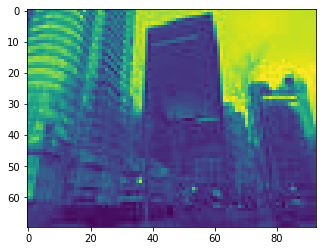

In [19]:

def rgb2gray(rgb_array: np.ndarray, r=0.2989, g=0.5870, b=0.1140):
    grayscale_array = (rgb_array[..., 0] * r +
                       rgb_array[..., 1] * g +
                       rgb_array[..., 2] * b)
    grayscale_array = np.round(grayscale_array)
    grayscale_array = np.asarray(grayscale_array, dtype=np.uint8)
    return grayscale_array

def load_recons(root = 'test_outs', shapes = orig_shapes):
    recons = []
    path = os.listdir(root)
    for f, s in zip(sorted(path, key=lambda x: int(x.replace(".jpg", ""))), shapes):
        img = Image.open(os.path.join(root, f))
        arr = np.asarray(img)
        arr = rgb2gray(arr)
        recons.append(arr)
    return recons

recs = load_recons()

plt.imshow(recs[3])

In [20]:
def load_centers_sizes(centers = test_data['crop_centers'], sizes = test_data['crop_sizes']):
    cts = []
    szs = []
    for i, j in zip(centers, sizes):
        cts.append(i)
        szs.append(j)
    return cts, szs
    
cts, szs = load_centers_sizes()

ct = 0
for i,j,k in zip(recs, cts, szs):
    ct += 1
    print(i.shape, j, k)
    print('='*20)
    if ct == 10:
        break

from folder_preparator import cropper

def crop_tests(recons = recs, crop_centrs = cts, crop_szs = szs):
    counter = 0
    for arr, i, j in zip(recons, crop_centrs, crop_szs):
            image, crop, target = cropper(arr, (j[0], j[1]), (i[0], i[1]))
            counter += 1
            Image.fromarray(target).save(f'test_final/{counter}.jpg')
            #Image.fromarray(image).save(f'test_final/{counter}_crop.jpg')

crop_tests()

(70, 93) (30, 25) (15, 5)
(70, 93) (34, 61) (19, 11)
(70, 93) (37, 52) (19, 17)
(70, 93) (30, 51) (7, 17)
(70, 93) (35, 48) (21, 7)
(70, 93) (33, 42) (21, 13)
(70, 93) (40, 27) (11, 15)
(70, 93) (41, 54) (9, 11)
(93, 70) (39, 32) (11, 11)
(93, 70) (31, 23) (5, 7)


In [21]:
smpl = test_data['images'][0]
im = Image.fromarray(smpl)
np.asarray(im).shape

ctt = 0
for k,i,j in zip(test_data['images'],test_data['crop_centers'], test_data['crop_sizes']):
    ctt += 1
    print(k.shape, j, i)
    if ctt == 10:
        break

(70, 93) (15, 5) (30, 25)
(70, 93) (19, 11) (34, 61)
(70, 93) (19, 17) (37, 52)
(70, 93) (7, 17) (30, 51)
(70, 93) (21, 7) (35, 48)
(70, 93) (21, 13) (33, 42)
(70, 93) (11, 15) (40, 27)
(70, 93) (9, 11) (41, 54)
(93, 70) (11, 11) (39, 32)
(93, 70) (5, 7) (31, 23)


In [22]:
def into_lst(root = 'test_final'):
    path = os.listdir(root)
    ar = []
    for f in sorted(path, key=lambda x: int(x.replace(".jpg", ""))):
        img = Image.open(os.path.join(root, f))
        arr = np.asarray(img)
        ar.append(arr)
    return ar

lst = into_lst()

In [23]:
with open('upload.pkl', 'wb') as f:
    pickle.dump(lst,f)

In [15]:
# with open('upload.pkl', 'rb') as f:
#     data = pickle.load(f)
# data[1].shape

(19, 11)